In [1]:
import numpy as np
from numba import jit
import time
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore")

G=1
c=1
M01 = 1.474 * 10**3

G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)                  ############ m / s

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4


from numba import jit
@jit(nopython = True)
def love_number(C,y):
  k2 = 8 / 5 * C ** 5 * (1 - 2 * C) **(2) * (2 + 2 * C * (y - 1) - y) * (2 * C * (6 - 3 * y + 3 * C * (5 * y - 8)) + 4 * C ** 3 * (13 - 11 * y + C * (3 * y - 2) + 2 * C ** 2 * (1 + y)) + 3 * (1 - 2 * C) ** 2 * (2 - y + 2 * C * (y - 1)) * (np.log(1 - 2 * C))) ** (-1)
  return k2


@jit(nopython = True)
def beta_and_H(r, p, H, m, beta, parr, earr):
    dp = p * 0.005

    el_3 = en_dens(parr, earr, p - 3 * dp)
    el_2 = en_dens(parr, earr, p - 2 * dp)
    el_1 = en_dens(parr, earr, p - 1 * dp)
    er_3 = en_dens(parr, earr, p + 3 * dp)
    er_2 = en_dens(parr, earr, p + 2 * dp)
    er_1 = en_dens(parr, earr, p + 1 * dp)

    de_dp = (-1 / 60 * el_3 + 3 / 20 * el_2 - 3 / 4 * el_1 + 3 / 4 * er_1 - 3 / 20 * er_2 + 1 / 60 * er_3) / dp

    #G = 6.67430e-11  # Gravitational constant
    #c = 299792458.0  # Speed of light
    G = 1
    c = 1

    e = en_dens(parr, earr, p)
    dbeta_dr = 2 * (1 - 2 * m / r ) ** (-1) *H * (-2 * np.pi * G / c ** 2 * (5 * e + 9 * p / c ** 2 + de_dp * c ** 2 * (e + p / c ** 2)) + 3 / r ** 2 + 2 * (1 - 2 * m / r ) ** (-1) * ( m / r ** 2 + G / c ** 4 * 4 * np.pi * r * p) ** 2) + 2 * (1 - 2 * m / r ) ** (-1) *beta / r * (-1 + m / r + 2 * np.pi * r ** 2 * G / c ** 2 * (e - p / c ** 2))

    dHdr = beta
    return dbeta_dr, dHdr

@jit(nopython=True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e

@jit(nopython = True)
def find_ind(arr, val):
    for i, item in enumerate(arr):
        if val > item:
            continue
        else:
            return i
    return len(arr)

class PressureOutOfRangeError(Exception):
    pass

@jit(nopython = True)
def en_dens(parr, earr, p):
  if p < min(parr) or p > max(parr):
    e = 0
  else:
    e = ene_interp(parr, earr, p)
  return e


@jit(nopython = True)
def ene_interp(pre_arr, ene_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        ene_val = (pressure - left_p)*(right_e - left_e)/(right_p - left_p) + left_e
    return ene_val

@jit(nopython = True)
def pre_interp(pre_arr, ene_arr, energy):
    if energy < min(ene_arr) or energy > max(ene_arr):
        raise PressureOutOfRangeError("Energy is out of range.")
    else:
        ind = find_ind(ene_arr, energy)
        left_p = pre_arr[ind - 1]
        right_p = pre_arr[ind]
        left_e = ene_arr[ind-1]
        right_e = ene_arr[ind]
        pre_val = (energy - left_e)*(right_p - left_p)/(right_e - left_e) + left_p
    return pre_val

def cs2_interp(cs2_arr, pre_arr, pressure):
    if pressure < min(pre_arr) or pressure > max(pre_arr):
        raise PressureOutOfRangeError("Pressure is out of range.")
    else:
        ind = find_ind(pre_arr, pressure)
        left_c = cs2_arr[ind - 1]
        right_c = cs2_arr[ind]
        left_p = pre_arr[ind-1]
        right_p = pre_arr[ind]
        cs2_val = (pressure - left_p)*(right_c - left_c)/(right_p - left_p) + left_c
    return cs2_val

@jit(nopython = True)
def Tov_eqn(P, r, m, dens, press, G, c, min_pressure):
    if P < min_pressure:
        return 0.0
    else:
        eden = ene_interp(press, dens, P)
        return -(G * ((P / c ** 2) + eden) * (m + 4 * np.pi * r ** 3 * P / c ** 2)) / (r * (r - 2 * G * m / c ** 2))

@jit(nopython = True)
def mass_eqn(r, ene):
    return 4 * np.pi * r ** 2 * ene


def TOV_module(cen_dens, pressure, density, exit_Pre,love=False, to_print=False):
    asi = 0
    P_exit =exit_Pre
    for i in range(len(cen_dens)):
        press = np.array(pressure)
        dens = np.array(density)
        d = cen_dens[i]
        P0 = pre_interp(press, dens, d)
        r = 10
        P = P0
        m = mass_eqn(r,d)
        h = 1
        a0 = 1
        H0 = a0*r**2
        beta0 = 2*a0*r
        min_pressure = min(press)
        beta = beta0
        H = H0
        if  love == True:
            #print("Entering Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                k1_dbeta_dr, k1_dHdr = beta_and_H(r, P, H, m, beta, press, dens)
                k2_dbeta_dr, k2_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k1_p, H + 0.5 * h * k1_dHdr, m + 0.5*h*k1_m, beta + 0.5*h*k1_dbeta_dr, press, dens)
                k3_dbeta_dr, k3_dHdr = beta_and_H(r + 0.5 * h, P + 0.5 * h * k2_p, H + 0.5 * h * k2_dHdr, m + 0.5*h*k2_m, beta + 0.5*h*k2_dbeta_dr, press, dens)
                k4_dbeta_dr, k4_dHdr = beta_and_H(r + h, P + h * k3_p, H + h * k3_dHdr, m + h*k3_m, beta + h*k3_dbeta_dr, press, dens)

                beta = beta + (h / 6.0) * (k1_dbeta_dr + 2 * k2_dbeta_dr + 2 * k3_dbeta_dr + k4_dbeta_dr)
                H = H + (h / 6.0) * (k1_dHdr + 2 * k2_dHdr + 2 * k3_dHdr + k4_dHdr)
                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            y = r * beta/ (H)
            C = m/(r)
            k2 = love_number(C,y)
            Com.append(C)
            Love.append(k2)
            if to_print == True:
                print("star ", i," done")
        else:
            #print("Entering No Love loop")
            while P > P_exit :
                k1_m = mass_eqn(r, ene_interp(press, dens, P))
                k2_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k3_m = mass_eqn(r + h / 2, ene_interp(press, dens, P))
                k4_m = mass_eqn(r + h, ene_interp(press, dens, P))

                k1_p = Tov_eqn(P, r, m, dens, press, G, c, min_pressure)
                k2_p = Tov_eqn(P + k1_p * h / 2, r + h / 2, m + k1_m * h / 2, dens, press, G, c, min_pressure)
                k3_p = Tov_eqn(P + k2_p * h / 2, r + h / 2, m + k2_m * h / 2, dens, press, G, c, min_pressure)
                k4_p = Tov_eqn(P + k3_p * h, r + h, m + k3_m * h, dens, press, G, c, min_pressure)

                P += h * (k1_p + 2 * k2_p + 2 * k3_p + k4_p) / 6
                m += h * (k1_m + 2 * k2_m + 2 * k3_m + k4_m) / 6
                r += h
            R.append(r/1000)
            M.append(m/M01)
            if to_print == True:
                print("star ", i," done")
    return R,M,Com,Love

In [35]:

import numpy as np
import matplotlib.pyplot as plt


#data1 = np.loadtxt('./EOS-Data/Had_EOS_13.dat')
# file = './EOS-Data/Had_EoS1'
# for i in range(0,10000):
#     data1 = np.loadtxt('./EOS-Data/Had_EoS1/Had_EOS_'+str(i)+'.dat')
#     plt.plot(data1[:,1], data1[:,0], label='Had_EOS_'+str(i))
data1 = np.loadtxt('eos_DD2BPS_hadronic_cs2.csv', delimiter=',',skiprows=1)
data2 = np.loadtxt('EOS-Data/new-eos_S_LY4_new.csv', delimiter=',',skiprows=1)


In [36]:
G1 = 6.67*10**(-11)             ############ N m^2/ kg^2
c1 = 3*10**(8)  

Mev_fm3_to_GU = 1.6* 10**32 * G1/c1**4

density_dat = data1[:, 2]
pressure_dat = data1[:, 3]

# sound_speed_dat = data1[:,2]

density_dat_GU = density_dat*Mev_fm3_to_GU
pressure_dat_GU = pressure_dat*Mev_fm3_to_GU

# density_dat_GU.astype(np.float64)
# pressure_dat_GU.astype(np.float64)

print(np.max(density_dat_GU), np.max(pressure_dat_GU))
print(np.min(density_dat_GU), np.min(pressure_dat_GU))

# print(density_dat_GU)
# print(density_dat_GU)



3.3839594469135796e-09 2.2416865382716047e-09
4.8682238419753086e-20 1.9990764049382715e-25


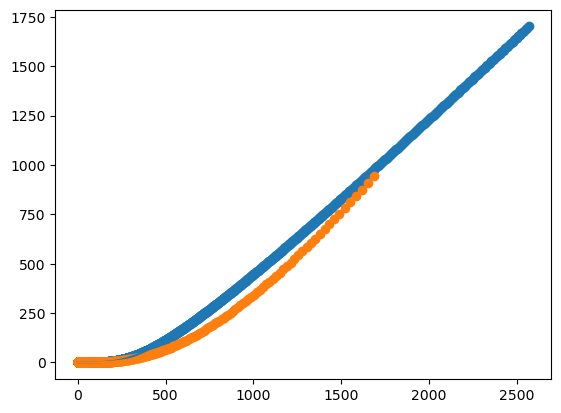

In [37]:
plt.plot(density_dat, pressure_dat, label='EOS')
plt.scatter(density_dat, pressure_dat, label='EOS')
# plt.plot(density_dat1, pressure_dat1, label='EOS1')
# plt.scatter(density_dat1, pressure_dat1, label='EOS1')
# plt.xlim(10,20000)
# plt.ylim(0.1, 10**4)



In [38]:
central_energy = np.logspace(np.log10(np.max(density_dat_GU)*0.999),np.log10( 2.072392843084521e-10),50)
#central_energy = np.asarray(central_energy[1])
print(np.max(central_energy), np.min(central_energy),central_energy[4])

3.3805754874666724e-09 2.072392843084521e-10 2.691593876576457e-09


In [39]:
M= []
R = []
Com = []
Love = []

In [40]:
R,M,Com,Love = TOV_module(central_energy, pressure_dat_GU,density_dat_GU,exit_Pre=np.min(1.1*pressure_dat_GU),love=True,to_print=True)

star  0  done


KeyboardInterrupt: 

In [ ]:
with open('Mass-Radius-DD2_Star.dat', 'w') as f:
    for i in range(len(M)):
        f.write(f'{R[i]} \t {M[i]} \t {Com[0]} \t {Love[i]} \n' )

In [109]:
print(R)

[18.492, 18.275, 17.993, 17.646, 17.237, 16.774, 16.267, 15.729, 15.178, 14.634]


In [110]:
print(M)

[14.990195867328845, 13.1101143575048, 11.276284648047147, 9.530429879572965, 7.910254839149173, 6.444873070836634, 5.154177635883301, 4.047294895972406, 3.122291279848589, 2.3688708291347247]


Text(0, 0.5, 'M/Msun')

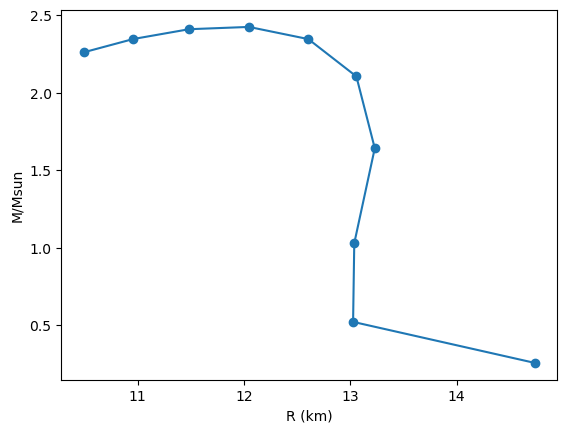

In [32]:
plt.plot(R,M, label='TOV')
plt.scatter(R,M, label='TOV')
plt.xlabel('R (km)')
plt.ylabel('M/Msun')
# plt.xlim(0,20)

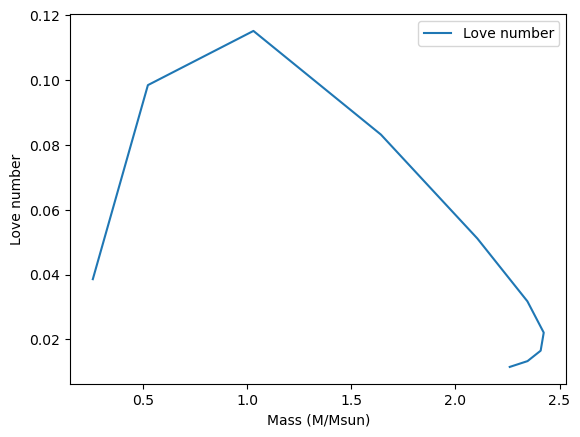

In [33]:
plt.plot(M,Love, label='Love number')
plt.xlabel('Mass (M/Msun)')
plt.ylabel('Love number')
plt.legend()


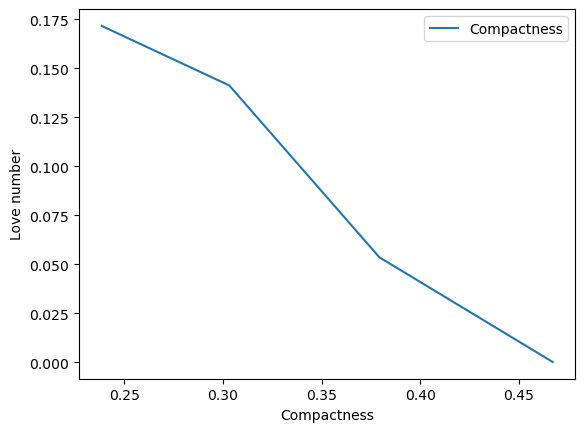

In [113]:
plt.plot(Com,Love, label='Compactness')
plt.xlabel('Compactness')
plt.ylabel('Love number')
plt.legend()

In [114]:
def Lambda(k2, C):
    return (2/3)*k2*C**(-5.0)



In [115]:
## For 1.36M and q = 0.73



m1 = np.asarray([1.85])
q = np.asarray([0.73,0.80,0.87,0.95])
m2 = m1*q

print(m2)

radius_from_mass = interp1d(M,R,fill_value='extrapolate')

r1 = radius_from_mass(m1)
r2 = radius_from_mass(m2)

print(r2)

love_from_mass = interp1d(M,Love,fill_value='extrapolate')
Compactness_from_mass = interp1d(M,Com,fill_value='extrapolate')

love1 = love_from_mass(m1)
love2 = love_from_mass(m2)

C1 = Compactness_from_mass(m1)
C2 = Compactness_from_mass(m2)

print(love2)

print(C1, C2)

print('M_TOV = ',np.max(M))
print('R_1.6 = ', radius_from_mass(1.6))

[1.3505 1.48   1.6095 1.7575]
[13.89869512 13.99219936 14.08570359 14.19256556]
[0.21272667 0.20750467 0.20228266 0.19631466]
[0.19410275] [0.15126386 0.16237024 0.17347662 0.18616962]
M_TOV =  14.990195867328845
R_1.6 =  14.07884420265871


In [116]:
lam1 = Lambda(love1,C1)
lam2 = Lambda(love2,C2)

In [117]:
lam1

array([465.98500803])

In [118]:
lam2

array([1790.83158589, 1225.75710699,  858.34648576,  585.21755568])

In [119]:
@jit(nopython = True)
def binary_tidal(lam1,lam2,mass1,mass2):
  lamb_t = (16/13)*((mass1 + 12 * mass2) * (lam1 * mass1**4) + (mass2 + 12 * mass1) * (lam2 * mass2**4))
  lamb = lamb_t/(mass1 + mass2)**5
  return lamb

In [120]:
tidal = binary_tidal(lam1,lam2,m1,m2)

tidal

array([875.40328757, 740.31987165, 627.55684927, 521.68456315])

Text(0.5, 1.0, 'Tidal deformability vs q')

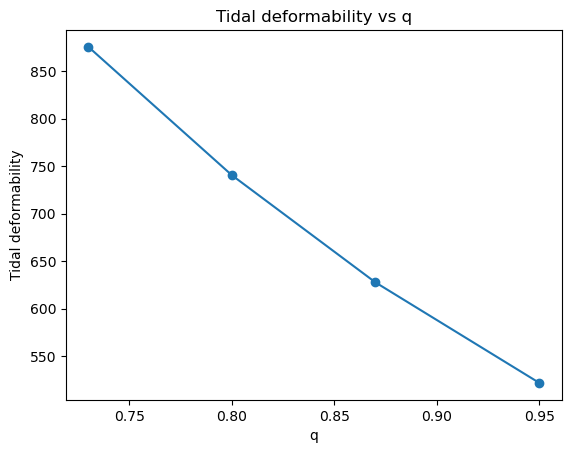

In [121]:
# fig,ax = plt.subplots(1,2)
plt.plot(q,tidal)
plt.scatter(q,tidal)
plt.xlabel('q')
plt.ylabel('Tidal deformability')
plt.title('Tidal deformability vs q')


In [122]:
with open('Mass-Radius-SLY_4-EOS_4-plot.dat', 'w') as f:
    for i in range(len(q)):
        f.write(f'{m1[0]} \t {m2[i]} \t {lam1[0]} \t {lam2[i]} \n' )

In [123]:
def ejecta_from_mass_ratio(m1,m2,lambda1,lambda2):

    log_ej = (-0.0719*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(-0.0719*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = np.exp(log_ej)

    ejcta_mass = M_dyn*1.9885e33



    return ejcta_mass

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
from numpy import pi

import bateman as bt
import thermalization as th
import heat as ht
import lightcurve as lc



c = 2.99792458e10
day = 86400.
Msun = 1.9885e33



%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
#fkappa = pd.read_csv('effective_kappa_A141_238.dat',delim_whitespace=True,header=None)
fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)
#fkappa = pd.read_csv('effective_kappa_141_238.dat',delim_whitespace=True,header=None)

kappa_effs = 0.02*np.ones((240,100))
for i in range(0,len(fkappa)):
    A = fkappa[0][i]
    Z = fkappa[1][i]
    kappa = np.sqrt(fkappa[3][i]*fkappa[4][i])
    kappa_effs[A][Z] = kappa

/var/folders/qf/j495f6rd5_52r4vxvnhky6jr0000gn/T/ipykernel_55824/2689731801.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)


In [126]:
ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)

##########Start input parameters
Amin = 85
Amax = 209

##########ejecta parameters for thermalization
# Mej = 0.1608*Msun
# vej = 0.1*c
# n = 4.5
# alpha_max = 4.0#v_max = alpha_max * vej
# alpha_min = 1.#v_min = alpha_min * vej

# #input parameters for the calculation of a light curve
# kappa_low = 0.5  #opacity [cm^2/g] for v > v_kappa
# kappa_high = 3.0 #opacity [cm^2/g] for v < v_kappa
# be_kappa = 0.2


/var/folders/qf/j495f6rd5_52r4vxvnhky6jr0000gn/T/ipykernel_55824/2945447140.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)


In [127]:

def lightcurve(v,alpha_max,alpha_min,n,kappa_low,kappa_high,be_kappa,m1,m2,lambda1,lambda2,M_TOV,R):
    import synphot
    from astropy import units as u
    c = 2.99792458e10
    vej = v*c
    G = 6.67e-8  # Gravitational constant

    M_thr = G*M_TOV*Msun/(c**2*R*1e5)

    log_ej = (-0.0719*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(-0.0719*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)

    M_dyn = 10**(log_ej)*1.9885e33

    log_M_disc = max(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/M_thr)/0.05957)))
    M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn + M_disc


    # print('Calculated {} for mass ratio {}'.format(Mej,(m2/m1)))

    # mass_ej = (-9.335/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)+114.17*(m2/m1)**(1.5465)-337.56*(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2))+(-9.335/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)+114.17*(m2/m1)**(1.5465)-337.56*(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2))
    # Mej = mass_ej*1.9885e30

    # if Mej < 0:
    #     Mej = 0.0



    beta = ht.calc_heating_rate(Mej,vej, Amin,Amax,ffraction,kappa_effs,alpha_max,alpha_min,n)
    heat_time = np.array(beta['t'])
    heat_rate = np.array(beta['electron_th'])+np.array(beta['gamma_th'])

    LC = lc.calc_lightcurve(Mej,vej,alpha_max,alpha_min,n,kappa_low,kappa_high,be_kappa,heat_time, heat_rate)

    # bandpass_labels = 'ubvri'
    # bandpasses = [
    # synphot.SpectralElement.from_filter(f'johnson_{label}')
    # for label in bandpass_labels]
    # seds = [
    # synphot.SourceSpectrum(synphot.BlackBody1D, temperature=TT)
    # * np.pi * (rr / 3.08567758128E+26)**2
    # for TT, rr in zip(LC['T'], LC['R'])]
    # abmags = [
    # [synphot.Observation(sed, bandpass).effstim(u.ABmag).value for sed in seds]
    # for bandpass in bandpasses]

    data = {'t':LC['t'],'LC':LC['LC'],'Temp':LC['T'],'Radius':LC['R'],'q':{m2/m1}}
    # df = pd.DataFrame(data=data)
    # df.to_csv('output_files/lightcurve.dat',sep=" ",index=False,header=None,columns=['t', 'LC', 'Temp', 'Radius'])

    # from matplotlib import rc
    # rc('text', usetex=False)
    # fig, ax = plt.subplots(figsize=(6.472135955, 4))
    # plt.xlim(0.1,30.)
    # plt.ylim(1.0e39,3.0e42)
    # plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
    # plt.xlabel(r"${\rm Time~since~merger~[day]}$")
    # plt.loglog(LC['t'],LC['LC'],label='bolometric',linestyle='-',linewidth=1.5,color='r')
    # plt.title(r'EOS = {EOS} M={M}M$_\odot$ v={v}c'.format(EOS=EOS,M=M,v=v))


    # plt.legend(loc='lower left',fontsize=14)
    # # plt.savefig("output_files/LC_A85.pdf",dpi=600,bbox_inches='tight')
    # plt.show()

    return data

In [128]:
data2 = np.loadtxt('Mass-Radius-SLY_4-EOS_4-plot.dat')
m1 = data2[:,0]
m2 = data2[:,1]
lambda1 = data2[:,2]
lambda2 = data2[:,3]

In [129]:
results = []
for i in range(len(m1)):
    result =lightcurve(0.1,4.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6))
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results.append(result)



/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.73 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.8 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(1e+39, 1e+42)

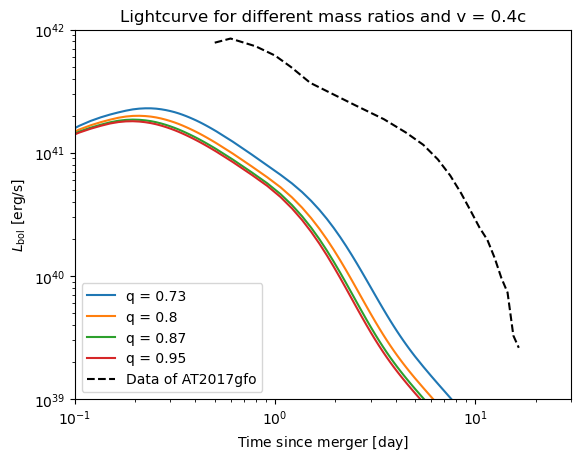

In [131]:
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results[i]['t'],results[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
#plt.loglog(t,L_bb,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.4c')
plt.xlim(0.1,30.)
plt.ylim(1.0e39,1.0e42)


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.73 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.8 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(0.1, 30.0)

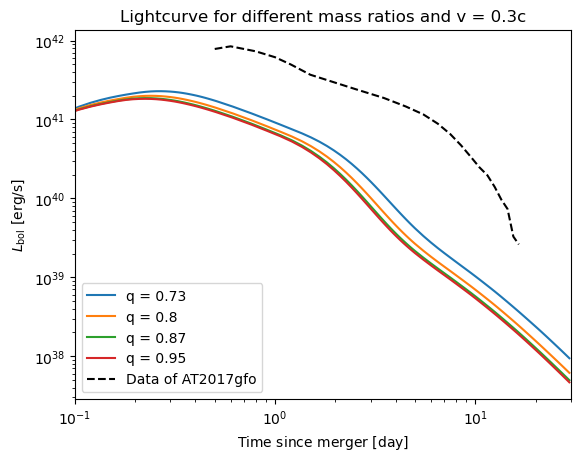

In [451]:
results1 = []
for i in range(len(m1)):
    result1 =lightcurve(0.1,3.0,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6))
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results1.append(result1)
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results1[i]['t'],results1[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.3c')
plt.xlim(0.1,30.)


In [452]:
results2 = []
for i in range(len(m1)):
    result2 =lightcurve(0.1,2.5,0.1,4.5,0.5,3.0,0.2,m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6))
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results2.append(result2)
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results2[i]['t'],results2[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.25c')
plt.xlim(0.1,30.)

/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

KeyboardInterrupt: 

/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.73 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.8 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(0.1, 30.0)

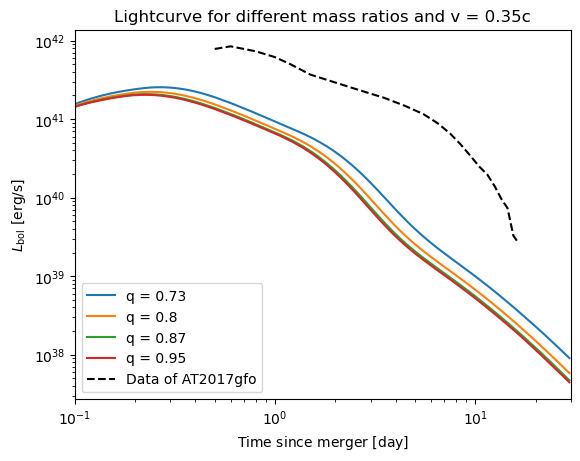

In [453]:
results3 = []
for i in range(len(m1)):
    result3 =lightcurve(0.1,3.5,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6))
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results3.append(result3)
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results3[i]['t'],results3[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.35c')
plt.xlim(0.1,30.)

/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.73 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.8 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.87 done


/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Codes/Lightcurve_Code/heat.py:75: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  fchain = pd.read_csv(filename,delim_whitespace=True,header=None)
/Users/divyansh/Documents/Research_Projects/Black-Hole-NS-Mass_GAP/Cod

Calculation for q = 0.95 done


(0.1, 30.0)

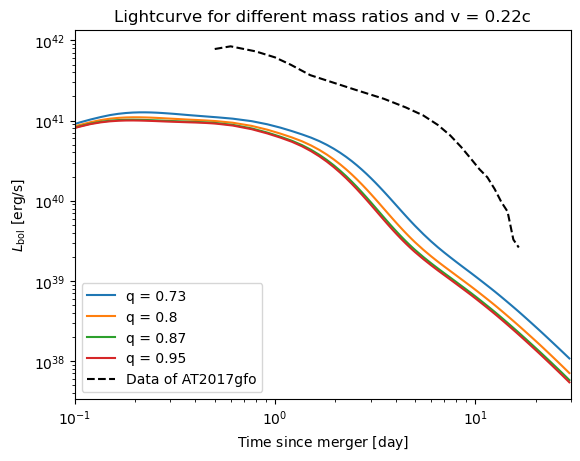

In [454]:
results3 = []
for i in range(len(m1)):
    result3 =lightcurve(0.1,2.2,1.0,4.5,0.5,3.0,0.2,m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6))
    print('Calculation for q = {} done'.format(m2[i]/m1[i]))
    results3.append(result3)
t = [0.5,0.6,0.8,1.0,1.2,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5]
L_int = [7.82e+41,8.45e+41,7.31e+41,6.15e+41,4.97e+41,3.69e+41,2.44e+41,1.87e+41,1.46e+41,1.16e+41,8.84e+40,6.53e+40,4.69e+40,3.36e+40,2.47e+40,1.96e+40,1.40e+40,9.64e+39,7.33e+39,3.28e+39,2.61e+39]
L_bb = [1.2e+42,1.3e+42,7.0e+41,5.5e+41,4.8e+41,3.6e+41,2.3e+41,1.7e+41,1.4e+41,1.0e+41,9.1e+40,7.0e+40,4.5e+40,2.9e+40,2.0e+40,3.0e+40,3.0e+40,2.1e+40,1.7e+40,7.7e+38,7.7e+38]

for i in range(len(m1)):
    plt.loglog(results3[i]['t'],results3[i]['LC'],label=f'q = {np.round(m2[i]/m1[i],3)}')
plt.loglog(t,L_int,label='Data of AT2017gfo',linestyle='--',linewidth=1.5,color='black')
plt.legend()
plt.ylabel(r"$L_{\rm bol}~[{\rm erg/s}]$")
plt.xlabel(r"${\rm Time~since~merger~[day]}$")
plt.title('Lightcurve for different mass ratios and v = 0.22c')
plt.xlim(0.1,30.)

In [133]:
def ejecta_from_mass_ratio(m1,m2,lambda1,lambda2,M_TOV,R):

    c = 2.99792458e10
    G = 6.67e-8  # Gravitational constant

    M_thr = G*M_TOV*Msun/(c**2*R*1e5)

    log_ej = (-0.0719*m1*((1/(0.360-0.0355*np.log(lambda1)+0.000705*np.log(lambda1)**2)) - 1)+ 0.2116*m2*(m1/m2)**(-2.905)-2.42/2)+(-0.0719*m2*((1/(0.360-0.0355*np.log(lambda2)+0.000705*np.log(lambda2)**2)) - 1)+ 0.2116*m1*(m2/m1)**(-2.905)-2.42/2)


    M_dyn = 10**(log_ej)*1.9885e33

    log_M_disc = max(-3,-31.335*(1-0.976*np.arctan((1.0474-(m1+m2)/M_thr)/0.05957)))
    M_disc = 10**(log_M_disc)*1.9885e33

    Mej = M_dyn + M_disc

    return Mej

In [5]:
# for i in range(25):
# #     print(ejecta_from_mass_ratio(m1[i],m2[i],lambda1[i],lambda2[i]))

#     plt.plot(ejecta_from_mass_ratio(m1[i],m2[i],lambda1[i],lambda2[i]),tidal[i])

ejecta_mass = []

for i in range(4):
    ejecta_mass.append(ejecta_from_mass_ratio(m1[i],m2[i],lambda1[i],lambda2[i]))

plt.plot(ejecta_mass,tidal)
plt.xlabel('Ejecta mass')
plt.ylabel('Tidal deformability')
plt.title('Tidal deformability vs Ejecta mass')

NameError: name 'm1' is not defined

In [134]:
for i in range(len(m1)):
    print(ejecta_from_mass_ratio(m1[i],m2[i],lambda1[i],lambda2[i],np.max(M),radius_from_mass(1.6)))

6.817318865656378e+30
5.134397382837329e+30
4.4559419998906015e+30
4.202787301029508e+30
